In [77]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import ast
import collections
from collections import Counter
from datetime import datetime

## 1: Import sessions, logs, arks

In [32]:
# import logs (first and last batch, for size)
first_logs_df = pd.read_csv("data_temp_month/clean_logs0.csv", index_col=0)
last_logs_df = pd.read_csv("data_temp_month/clean_logs21.csv", index_col=0)
sessions_df = pd.read_csv("data_temp_month/enriched_sessions/enriched_sessions.csv", index_col=0)
sessions_rh_df = pd.read_csv("data_temp_month/enriched_sessions/rh_sessions.csv", index_col=0)
arks_counts = pd.read_csv("arks_temp_month/final_arks_counts.csv", index_col=0)
arks_dict = pd.read_csv('arks_final_month/arks_dict.csv', index_col=0)

## 2: Statistics on the logs

We run a few statistics on the logs and on the arks.

In [33]:
first_date = first_logs_df['Date'].min()
last_date = last_logs_df['Date'].max()

In [36]:
print("We have logs from", first_date, "to", last_date)

We have logs from 2016-01-31 13:00:13+01:00 to 2016-02-29 05:36:46+01:00


In [37]:
# function  to calculate the percentage of a specific value in a column of a dataframe
# we will use it to get the number of unknown values of certain columns
def calculate_percentage(df, column, value):
    # count occurrences of the value in the column
    count_value = df[column].value_counts().get(value, 0)
    
    # if the value is NaN, count NaN values directly
    if pd.isna(value):
        count_value = df[column].isna().sum()
    
    # calculate percentage
    percentage = count_value / len(df) * 100
    
    return percentage

In [38]:
# percentage of unknown referrers
percentage_unknown_referrer_first = calculate_percentage(first_logs_df, 'Referrer', '-')
percentage_unknown_referrer_last = calculate_percentage(last_logs_df, 'Referrer', '-')
print("Percentage of unknown referrers: ", np.mean(percentage_unknown_referrer))

Percentage of unknown referrers:  16.054745848453102


In [39]:
# convert string representations to actual lists
first_logs_df['search_terms'] = first_logs_df['search_terms'].apply(ast.literal_eval)
last_logs_df['search_terms'] = last_logs_df['search_terms'].apply(ast.literal_eval)

# count occurrences of empty lists in the 'search_terms' column
nb_non_search_first = (first_logs_df['search_terms'].apply(lambda x: len(x) == 0)).sum()
nb_non_search_last = (last_logs_df['search_terms'].apply(lambda x: len(x) == 0)).sum()

# get percentage of non-search request in all logs
percentage_non_search_first = nb_non_search_first/len(first_logs_df) * 100
percentage_non_search_last = nb_non_search_last/len(last_logs_df) * 100

print("Percentage of non-search requests : ", np.mean(percentage_non_search))

Percentage of non-search requests :  98.3055534532824


We want to know the types and themes of the top 10% of most / least visible arks for rabbit holes and normal sessions.

In [65]:
# extract arks that are only in rabbit hole sessions
arks_in_rh_sessions = sessions_rh_df['Ark_list'].explode().dropna()

# convert the ARKs to a list
arks_list = arks_in_rh_sessions.tolist()

extracted_arks = []
for arks_string in arks_list:
    # remove leading and trailing square brackets and quotes, then split by comma and space
    arks = arks_string.strip("[]").replace("'", "").split(", ")
    # extend the extracted_arks list with the ARKs from the current string
    extracted_arks.extend(arks)


# get unique ARKs
unique_arks = set(extracted_arks)

# convert the unique ARKs to a list
unique_arks_list = list(unique_arks)

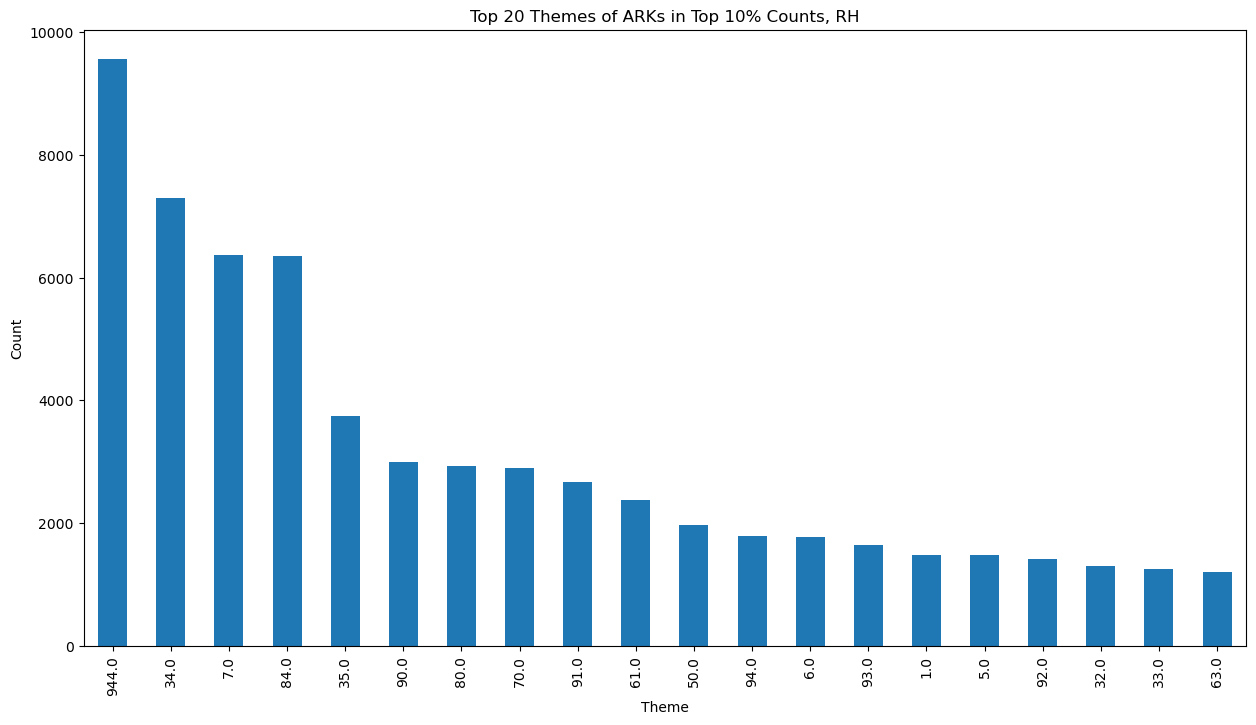

<Figure size 640x480 with 0 Axes>

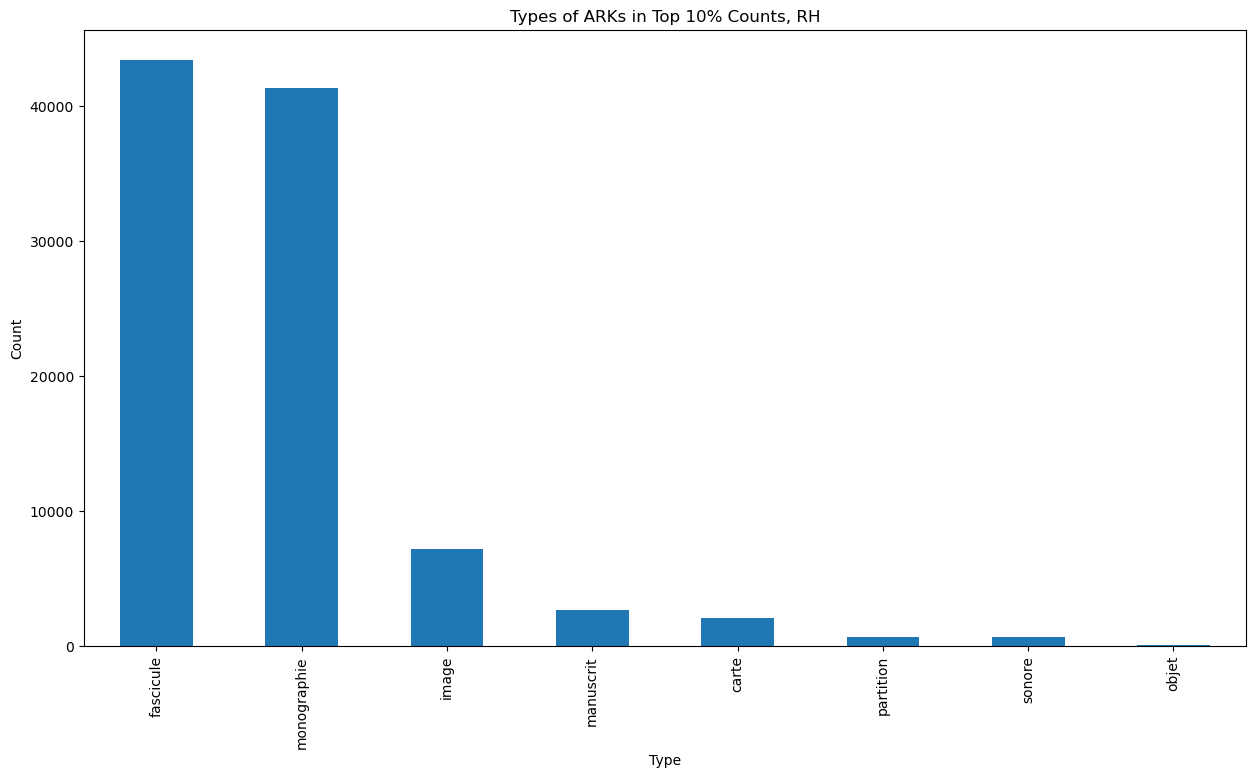

<Figure size 640x480 with 0 Axes>

In [68]:
# filter arks_counts to include only ARKs present in rh sessions
filtered_arks_counts = arks_counts[arks_counts['Ark'].isin(unique_arks_list)]

# get the top 10% count threshold for filtered ARKs
top_10_percent_threshold = filtered_arks_counts['Count'].quantile(0.9)

# filter the ARKs in the top 10% counts
top_10_percent_arks = filtered_arks_counts[filtered_arks_counts['Count'] >= top_10_percent_threshold]

# retrieve types and themes for the top 10% ARKs from arks_dict DataFrame
top_10_percent_arks_info = pd.merge(top_10_percent_arks, arks_dict, left_on='Ark', right_index=True, how='left')

# filter the top 20 themes
top_20_themes = top_10_percent_arks_info['Theme'].value_counts().nlargest(20)

# plot the top 20 themes
plt.figure(figsize=(15, 8))
top_10_percent_arks_info[top_10_percent_arks_info['Theme'].isin(top_20_themes.index)]['Theme'].value_counts().plot(kind='bar')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.title('Top 20 Themes of ARKs in Top 10% Counts, RH')
plt.savefig('plots/top_themes_most_vis_arks_rh.png')
plt.show()


# plot the types for the top 10% ARKs
plt.figure(figsize=(15, 8))
top_10_percent_arks_info['Type'].value_counts().plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Types of ARKs in Top 10% Counts, RH')
plt.savefig('plots/top_types_most_vis_arks_rh.png')
plt.show()


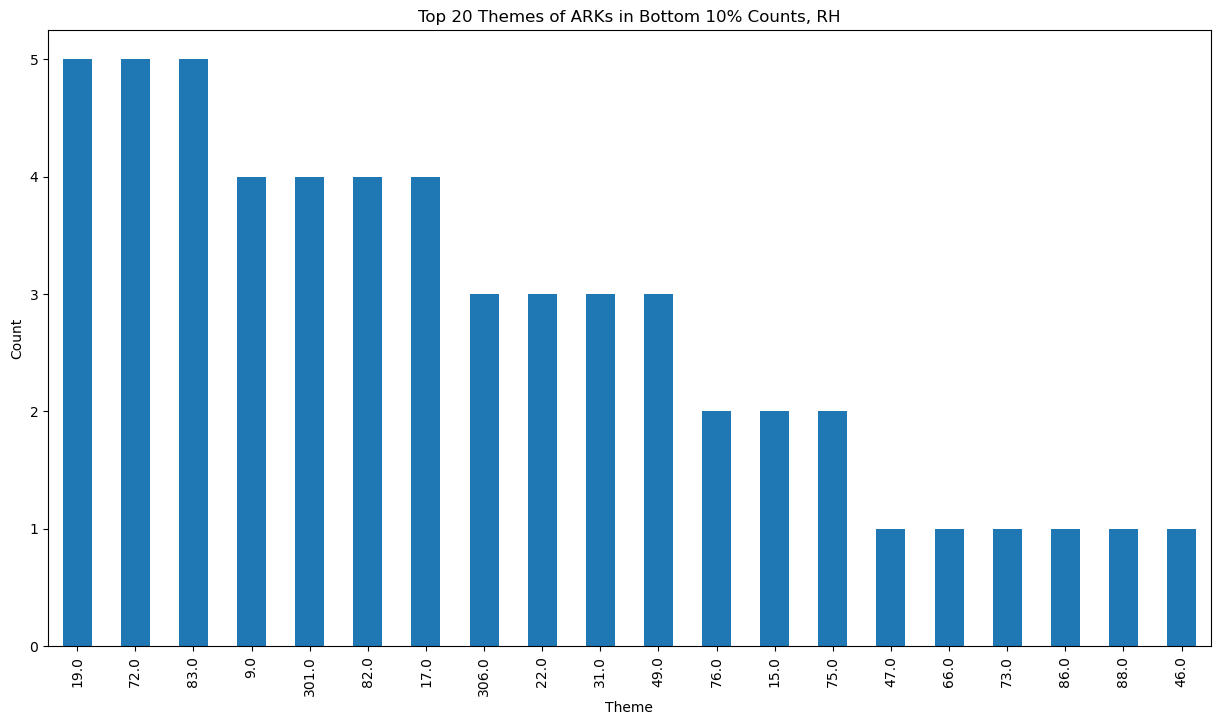

<Figure size 640x480 with 0 Axes>

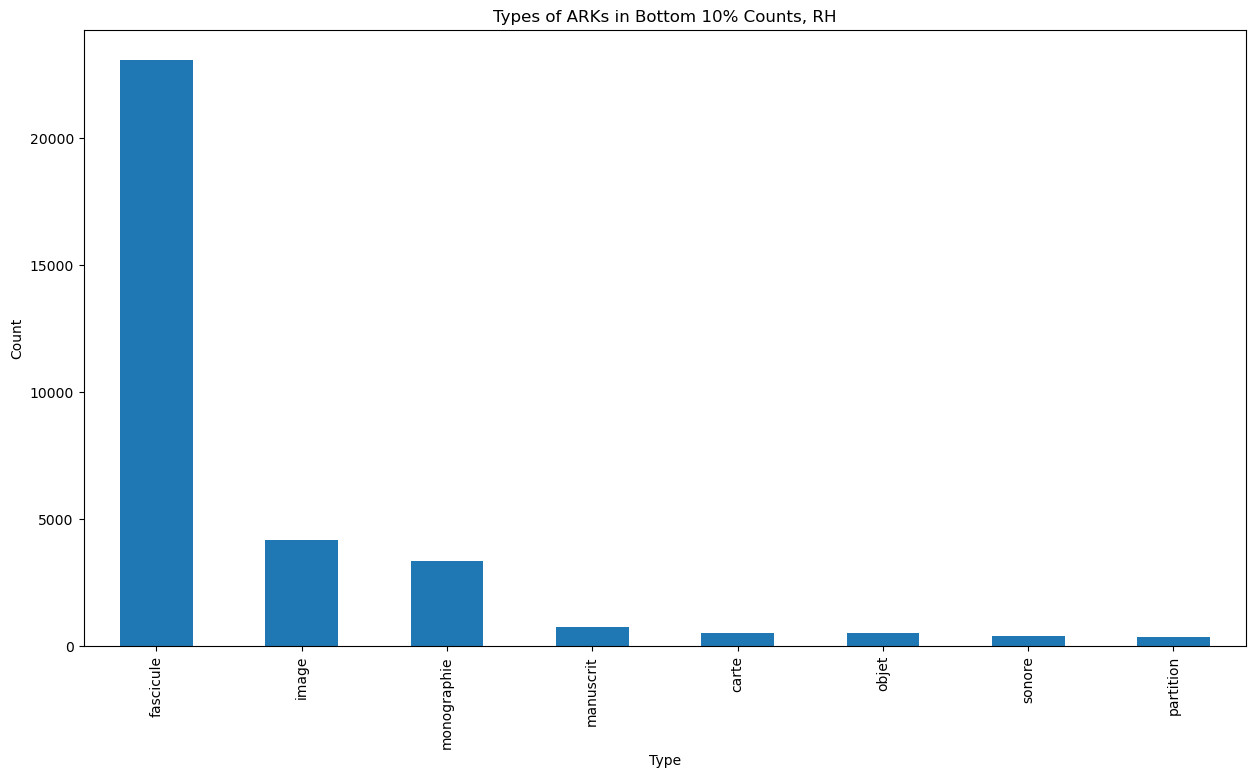

<Figure size 640x480 with 0 Axes>

In [69]:
# filter arks_counts to include only ARKs present in rabbit hole sessions
filtered_arks_counts = arks_counts[arks_counts['Ark'].isin(unique_arks_list)]

# get the bottom 10% count threshold for filtered ARKs
bottom_10_percent_threshold = filtered_arks_counts['Count'].quantile(0.1)

# filter the ARKs in the bottom 10% counts
bottom_10_percent_arks = filtered_arks_counts[filtered_arks_counts['Count'] <= bottom_10_percent_threshold]

# retrieve types and themes for the bottom 10% ARKs from arks_dict DataFrame
bottom_10_percent_arks_info = pd.merge(bottom_10_percent_arks, arks_dict, left_on='Ark', right_index=True, how='left')

# filter the top 20 themes
bottom_20_themes = bottom_10_percent_arks_info['Theme'].value_counts().nsmallest(20)

# plot the top 20 themes
plt.figure(figsize=(15, 8))
bottom_10_percent_arks_info[bottom_10_percent_arks_info['Theme'].isin(bottom_20_themes.index)]['Theme'].value_counts().plot(kind='bar')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.title('Top 20 Themes of ARKs in Bottom 10% Counts, RH')
plt.savefig('plots/top_themes_least_vis_arks_rh.png')
plt.show()

# plot the types for the bottom 10% ARKs
plt.figure(figsize=(15, 8))
bottom_10_percent_arks_info['Type'].value_counts().plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Types of ARKs in Bottom 10% Counts, RH')
plt.savefig('plots/top_types_least_vis_arks_rh.png')
plt.show()


Same process for all sessions.

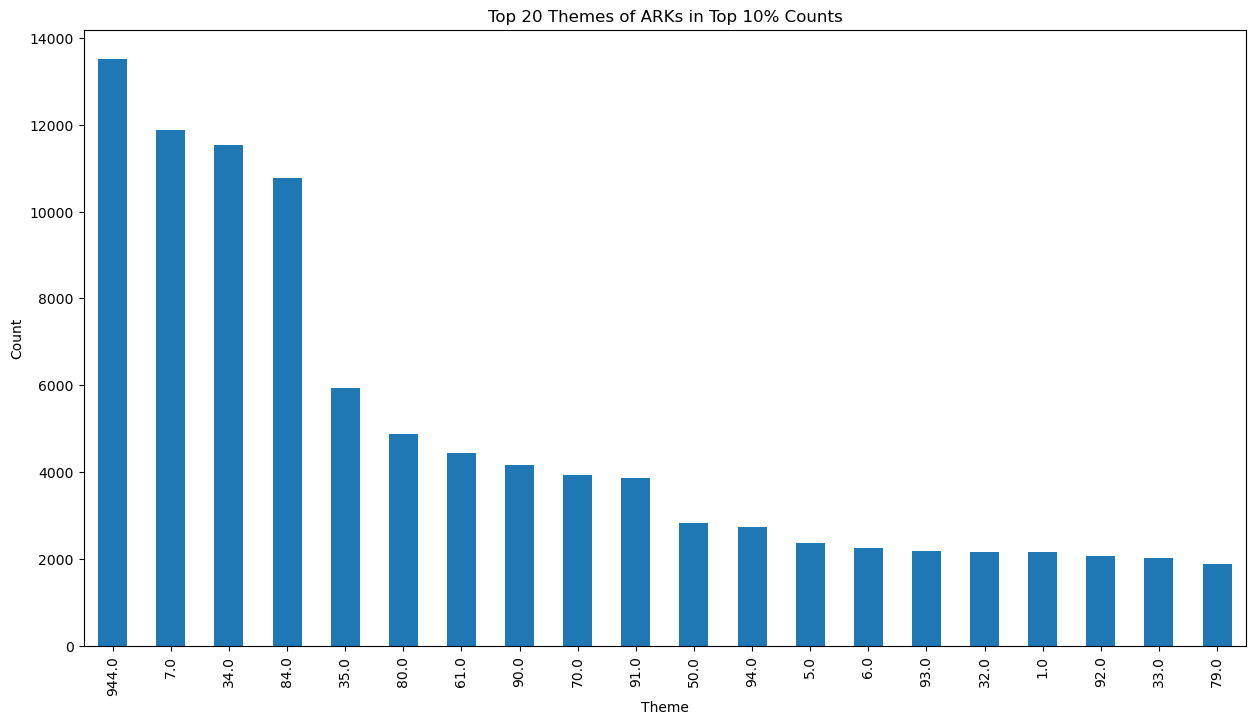

<Figure size 640x480 with 0 Axes>

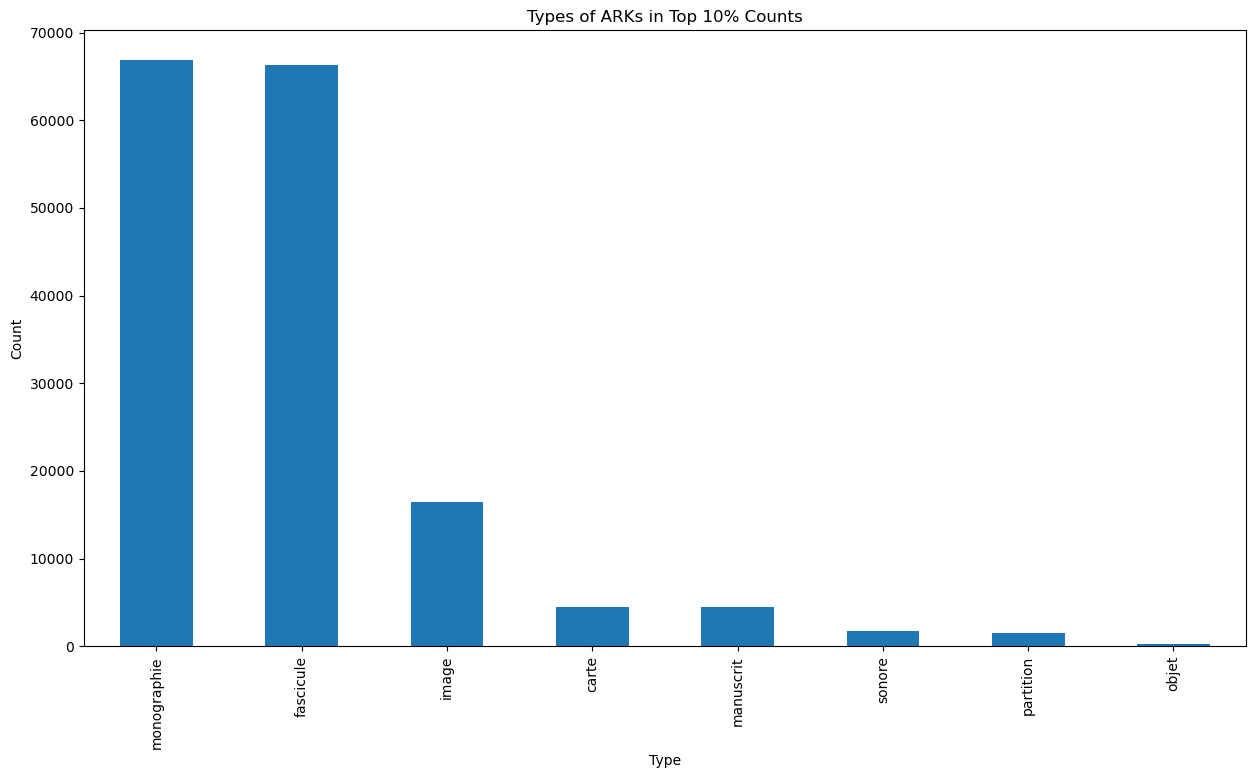

<Figure size 640x480 with 0 Axes>

In [48]:
# calculate the top 10% count threshold
top_10_percent_threshold = arks_counts['Count'].quantile(0.9)

# filter the ARKs in the top 10% counts
top_10_percent_arks = arks_counts[arks_counts['Count'] >= top_10_percent_threshold]

# retrieve types and themes for the top 10% ARKs from arks_dict DataFrame
top_10_percent_arks_info = pd.merge(top_10_percent_arks, arks_dict, left_on='Ark', right_index=True, how='left')

# filter the top 20 themes
top_20_themes = top_10_percent_arks_info['Theme'].value_counts().nlargest(20)

# plot the top 20 themes
plt.figure(figsize=(15, 8))
top_10_percent_arks_info[top_10_percent_arks_info['Theme'].isin(top_20_themes.index)]['Theme'].value_counts().plot(kind='bar')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.title('Top 20 Themes of ARKs in Top 10% Counts')
plt.savefig('plots/top_themes_most_vis_arks.png')
plt.show()


# plot the types for the top 10% ARKs
plt.figure(figsize=(15, 8))
top_10_percent_arks_info['Type'].value_counts().plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Types of ARKs in Top 10% Counts')
plt.savefig('plots/top_types_most_vis_arks.png')
plt.show()

944 : History and geography of France and regions, 7 : Arts, 34 : Droit, 84.0 : Littérature Française, 35.0 : Public administration and military science

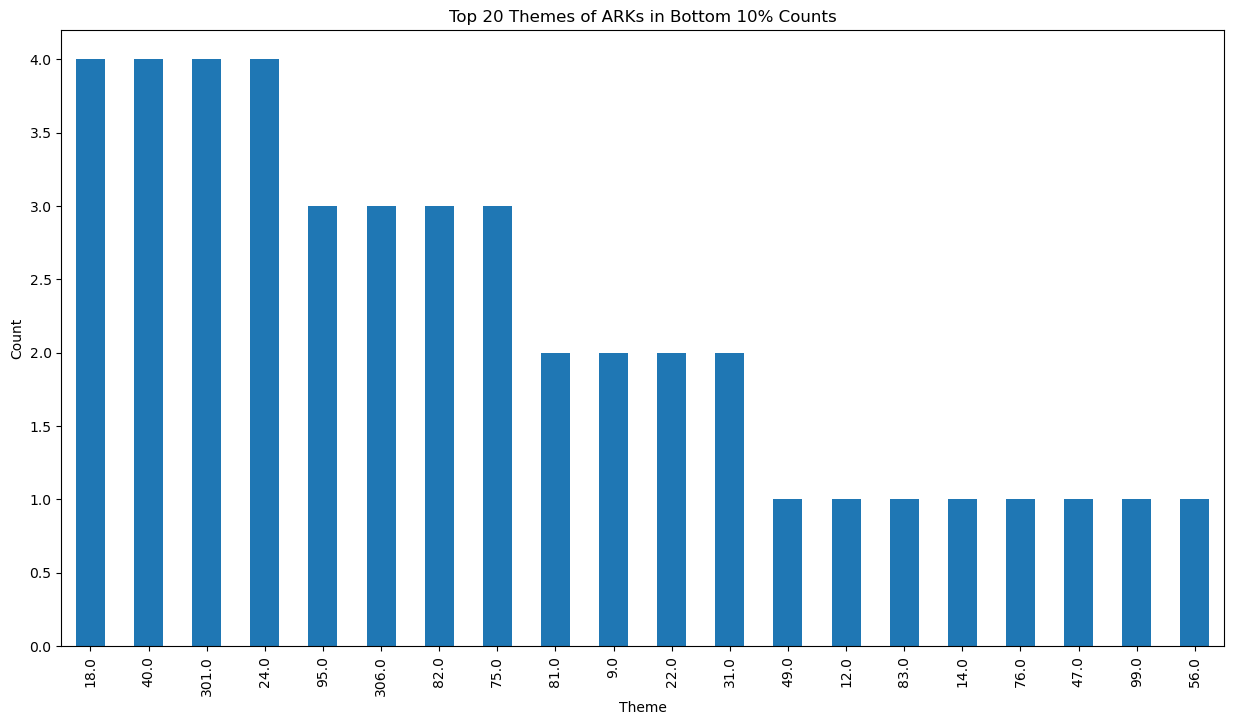

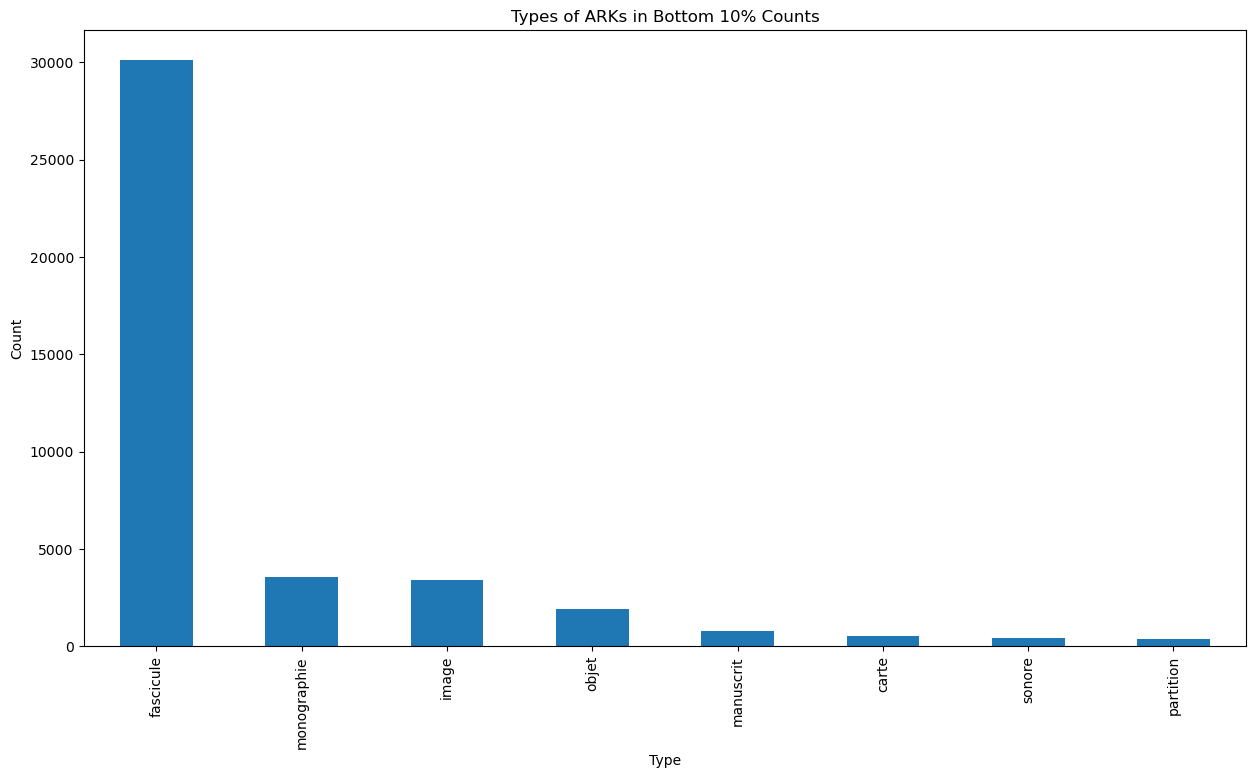

<Figure size 640x480 with 0 Axes>

In [53]:
# calculate the bottom 10% count threshold
bottom_10_percent_threshold = arks_counts['Count'].quantile(0.1)

# filter the ARKs in the bottom 10% counts
bottom_10_percent_arks = arks_counts[arks_counts['Count'] <= bottom_10_percent_threshold]

# retrieve types and themes for the bottom 10% ARKs from arks_dict DataFrame
bottom_10_percent_arks_info = pd.merge(bottom_10_percent_arks, arks_dict, left_on='Ark', right_index=True, how='left')

# filter the top 20 themes
bottom_20_themes = bottom_10_percent_arks_info['Theme'].value_counts().nsmallest(20)

# plot the top 20 themes
plt.figure(figsize=(15, 8))
bottom_10_percent_arks_info[bottom_10_percent_arks_info['Theme'].isin(bottom_20_themes.index)]['Theme'].value_counts().plot(kind='bar')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.title('Top 20 Themes of ARKs in Bottom 10% Counts')
plt.savefig('plots/top_themes_least_vis_arks.png')
plt.show()


# plot the types for the bottom 10% ARKs
plt.figure(figsize=(15, 8))
bottom_10_percent_arks_info['Type'].value_counts().plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Types of ARKs in Bottom 10% Counts')
plt.savefig('plots/top_types_most_vis_arks.png')
plt.show()


18.0 : Ancient, Medieval and Eastern Philosophy, 40.0 : Language, 301.0 : Sociology and Anthropology, 24.0 : Christian Practice and Observance, 95.0 : History of Asia

## 3: Statistics on the sessions (RH and non RH)

We plot some statistics on the sessions, first the occurrences of search terms.

In [73]:
def extract_non_empty_terms(search_terms):
    # convert string representation of list to actual list
    search_terms_list = ast.literal_eval(search_terms)
    # filter out non-empty terms
    non_empty_terms = [term for term in search_terms_list if term != '[]']
    return non_empty_terms

In [74]:
search_terms_col = sessions_df['search_terms']
non_empty_search_terms = [extract_non_empty_terms(term) for term in search_terms_col]

In [75]:
non_empty_search_terms

[["['cathare']",
  "['cathare']",
  "['cathare']",
  "['cathare']",
  "['cathare']",
  "['cathare']",
  "['cathare']",
  "['patarin']",
  "['patarin']",
  "['patarin']",
  "['patarin']",
  "['patarin']",
  "['arnaldiste']",
  "['arnaldiste']"],
 ["['annonciation de cortone']",
  "['annonciation de cortone']",
  "['annonciation 1434 fra angelico']",
  "['annonciation 1434 fra angelico']"],
 ["['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles']",
  "['Cicéri, Pierre-Luc-Charles'

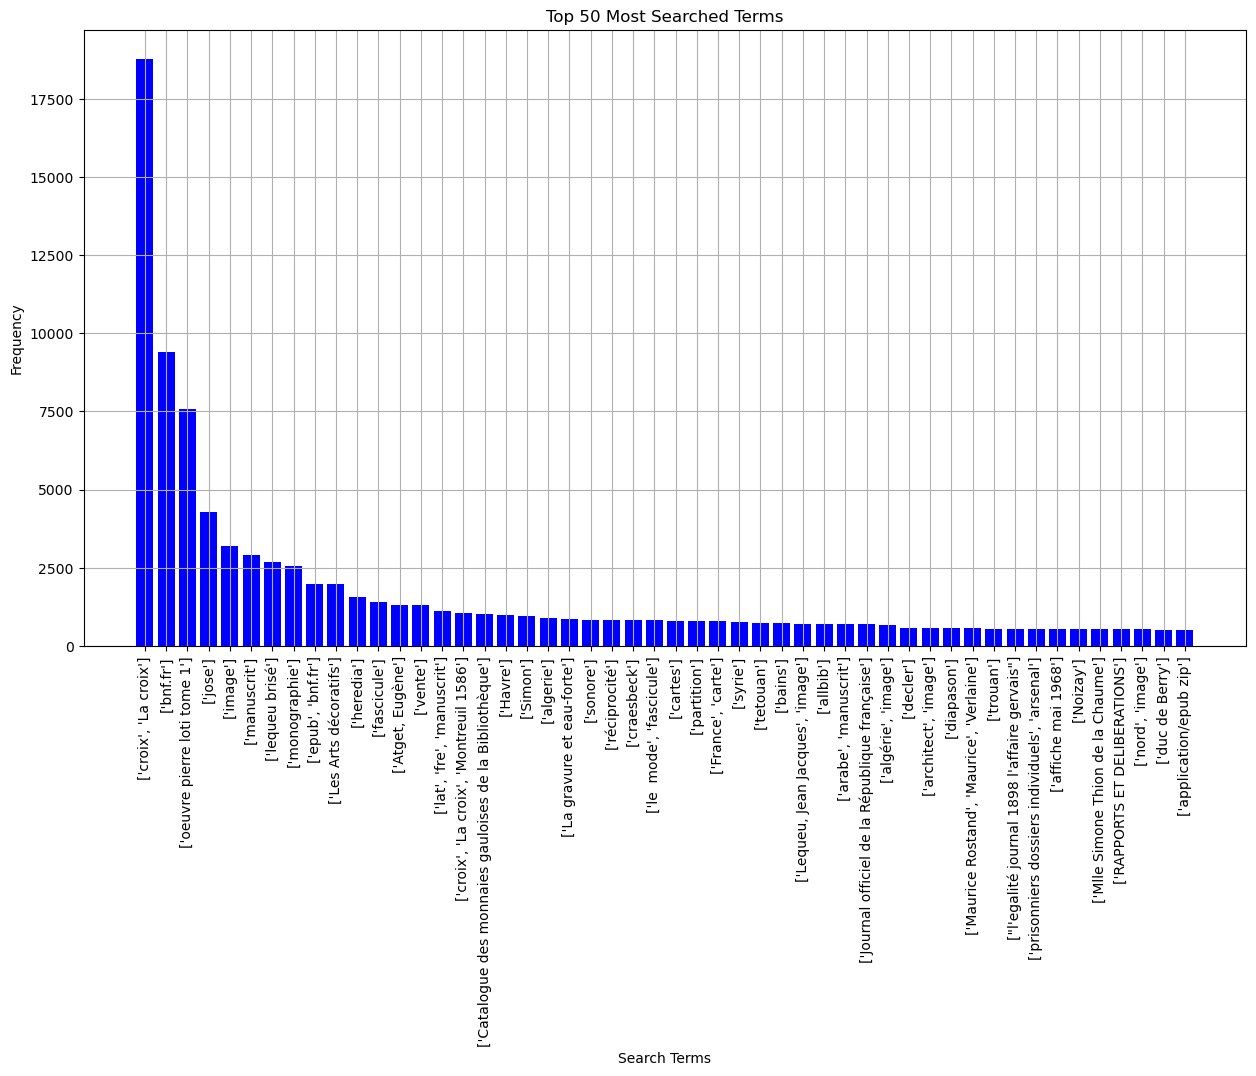

<Figure size 640x480 with 0 Axes>

In [91]:
# flatten the list of lists
flat_search_terms = [term for sublist in non_empty_search_terms for term in sublist]

# count the frequency of each search term
term_counts = collections.Counter(flat_search_terms)

# get the 50 most frequent search terms
top_50_terms = term_counts.most_common(50)

# separate the terms and their counts for plotting
terms, counts = zip(*top_50_terms)

# visualize the results using a bar chart
plt.figure(figsize=(15, 8))
plt.bar(terms, counts, color='blue')
plt.xlabel('Search Terms')
plt.ylabel('Frequency')
plt.title('Top 50 Most Searched Terms')
plt.xticks(rotation=90)
plt.grid(True)
plt.savefig("plots/top50search.png")
plt.show()


Same for RH sessions.

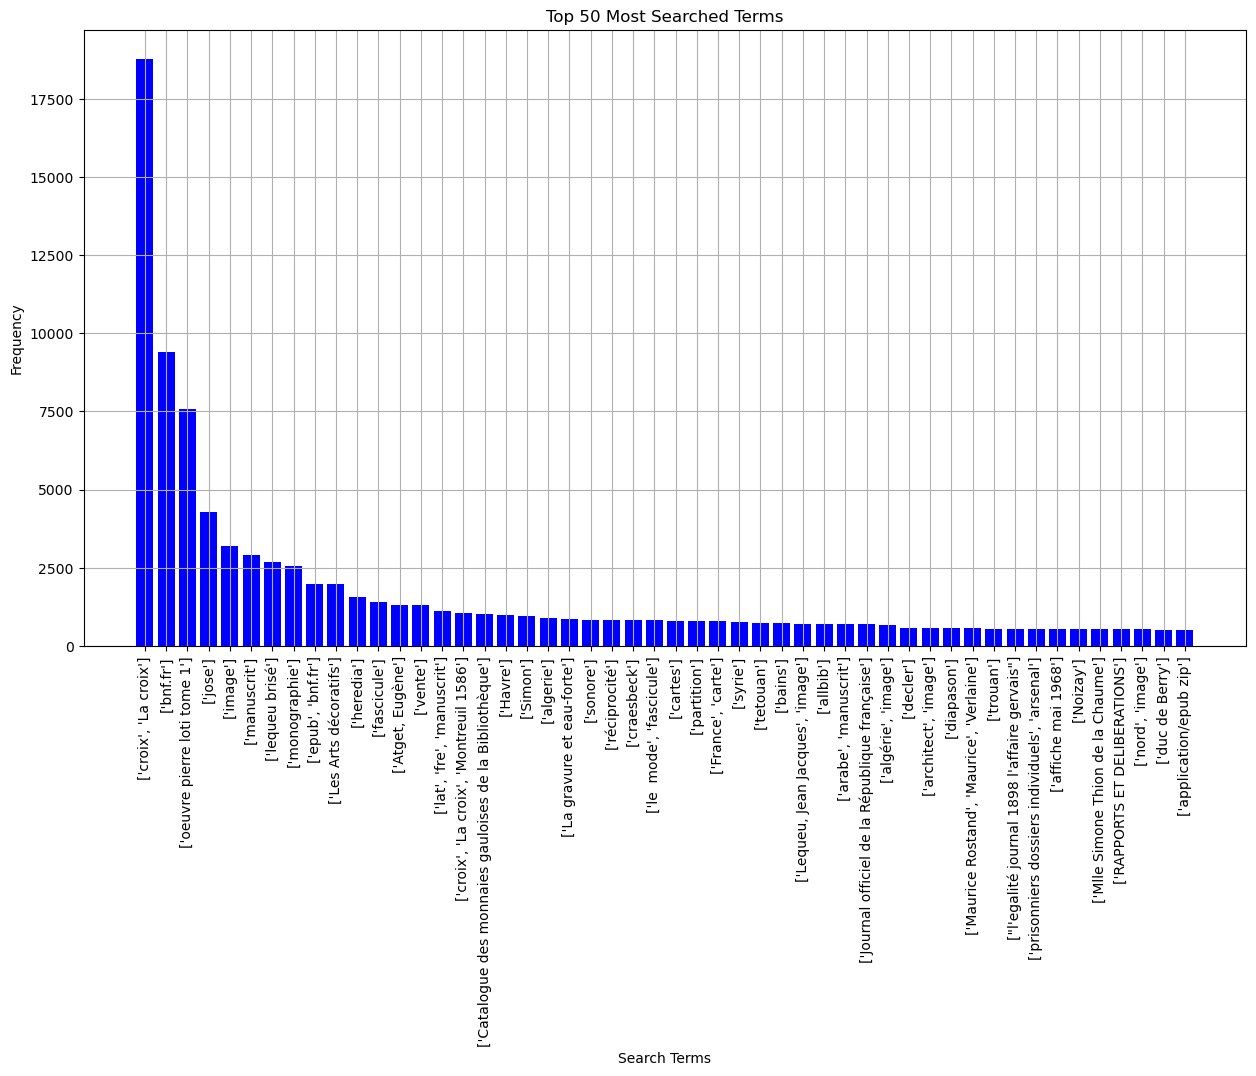

<Figure size 640x480 with 0 Axes>

In [92]:
search_terms_col_rh = sessions_rh_df['search_terms']
non_empty_search_terms_rh = [extract_non_empty_terms(term) for term in search_terms_col_rh]

# flatten the list of lists
flat_search_terms = [term for sublist in non_empty_search_terms_rh for term in sublist]

# count the frequency of each search term
term_counts = collections.Counter(flat_search_terms)

# get the 50 most frequent search terms
top_50_terms = term_counts.most_common(50)

# separate the terms and their counts for plotting
terms, counts = zip(*top_50_terms)

# visualize the results using a bar chart
plt.figure(figsize=(15, 8))
plt.bar(terms, counts, color='blue')
plt.xlabel('Search Terms')
plt.ylabel('Frequency')
plt.title('Top 50 Most Searched Terms')
plt.xticks(rotation=90)
plt.grid(True)
plt.savefig("plots/top50search_rh.png")
plt.show()

We look at the correlation between the length of a sessions and the mean / min visibility.

In [88]:
# correlation
# Compute correlation between 'length_session' and 'mean_visibility'
correlation_length_meanvisibility = sessions_df[['length_minutes', 'mean_visibility']].corr().iloc[0, 1]

# Compute correlation between 'min_visibility' and 'length_session'
correlation_minvisibility_length = sessions_df[['min_visibility', 'length_minutes']].corr().iloc[0, 1]

# Show the computed correlations
print("For sessions:")
print("Correlation between length_session and mean_visibility:", correlation_length_meanvisibility)
print("Correlation between min_visibility and length_session:", correlation_minvisibility_length)


Correlation between length_session and mean_visibility: 0.0015220583351400368
Correlation between min_visibility and length_session: -0.002058232606976053


In [89]:
# correlation
# Compute correlation between 'length_session' and 'mean_visibility'
correlation_length_meanvisibility = sessions_rh_df[['length_minutes', 'mean_visibility']].corr().iloc[0, 1]

# Compute correlation between 'min_visibility' and 'length_session'
correlation_minvisibility_length = sessions_rh_df[['min_visibility', 'length_minutes']].corr().iloc[0, 1]

# Show the computed correlations
print("For RH sessions:")
print("Correlation between length_session and mean_visibility:", correlation_length_meanvisibility)
print("Correlation between min_visibility and length_session:", correlation_minvisibility_length)


Correlation between length_session and mean_visibility: 0.008777594412959536
Correlation between min_visibility and length_session: 0.006818761112578294


These correlations are not significant.

In [101]:
sessions_df.columns

Index(['session_id', 'Ark', 'Date', 'Referrer', 'search_terms',
       'first_referrer', 'length_minutes', 'visibility', 'min_visibility',
       'mean_visibility', 'min_first_3', 'mean_first_3', 'min_last_3',
       'mean_last_3', 'variation_min_vis', 'variation_mean_vis', 'Ark_list',
       'themes', 'types', 'very_long', 'nb_docs', '>=10_docs',
       'top_10%_length', 'top_5%_length', 'nb_types', 'nb_themes',
       'diversified', 'diversified_restrictive', 'diversified_restrictive_5',
       'diversified_5'],
      dtype='object')

In [121]:
def extract_first_date(date_str):
    try:
        # split the string to get the first date, remove extra characters
        first_date_str = date_str.split(',')[0].strip("[] '\"")
        # convert to datetime
        first_date = pd.to_datetime(first_date_str)
        return first_date
    except Exception as e:
        return pd.NaT

In [122]:
# get first date of the sessions to find and plot hour, day of the week
sessions_df['first_date'] = sessions_df['Date'].apply(extract_first_date)
sessions_rh_df['first_date'] = sessions_rh_df['Date'].apply(extract_first_date)


In [123]:
def get_day_name(date):
    try:
        first_date = pd.to_datetime(date)
        return first_date.day_name()
    except (ValueError, IndexError):
        return 'Invalid Date'

In [124]:
# statistics day of the week beg. of sessions
sessions_df['day_beginning'] = sessions_df['first_date'].dt.day_name()
sessions_rh_df['day_beginning'] = sessions_rh_df['first_date'].dt.day_name()


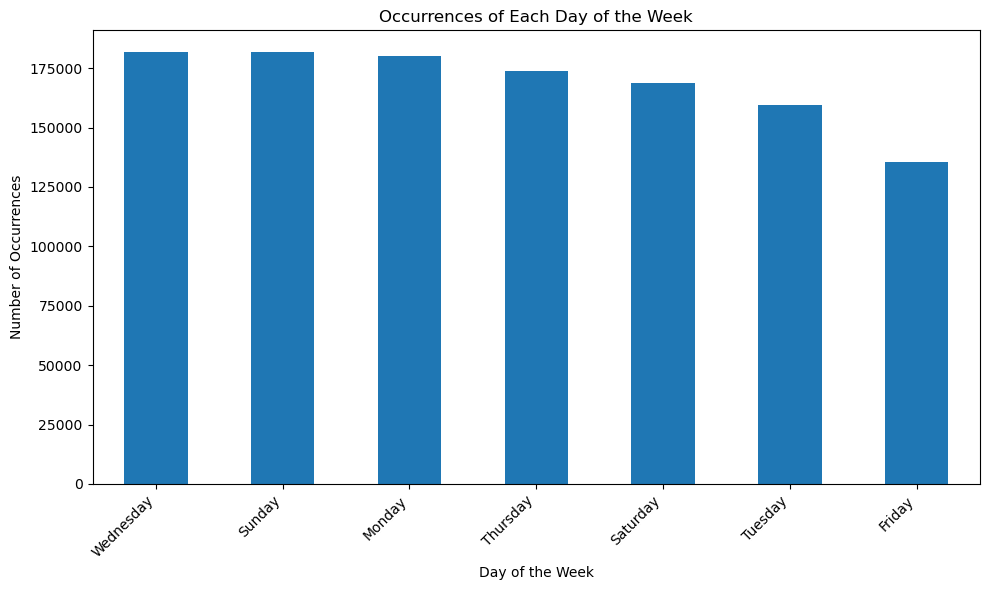

<Figure size 640x480 with 0 Axes>

In [125]:
# Count occurrences of each day of the week
day_counts = sessions_df['day_beginning'].value_counts()

# Plot the occurrences
plt.figure(figsize=(10, 6))
day_counts.plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Occurrences')
plt.title('Occurrences of Each Day of the Week')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/day_week.png")
plt.show()

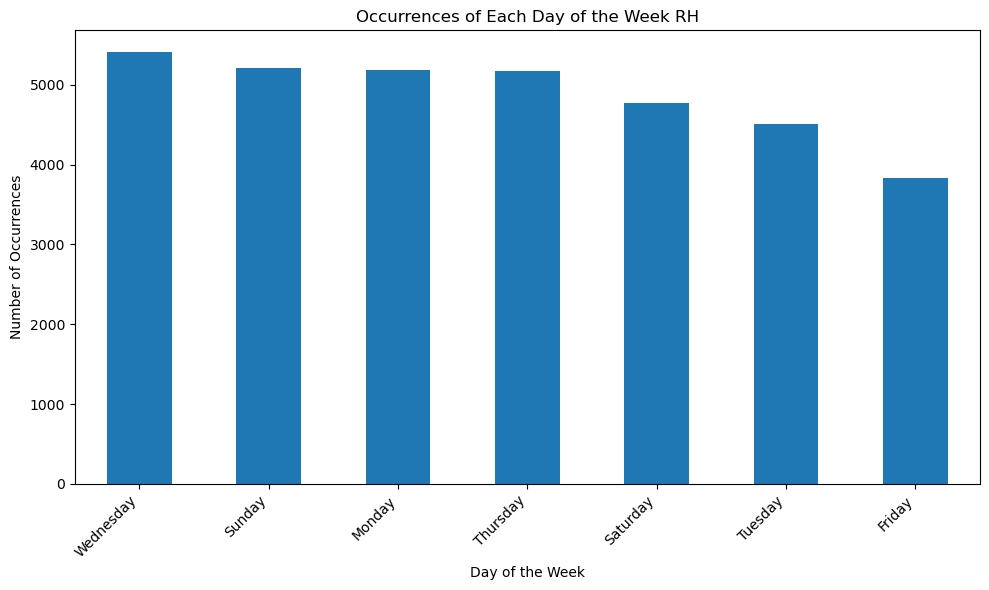

<Figure size 640x480 with 0 Axes>

In [131]:
# Count occurrences of each day of the week
day_counts = sessions_rh_df['day_beginning'].value_counts()

# Plot the occurrences
plt.figure(figsize=(10, 6))
day_counts.plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Occurrences')
plt.title('Occurrences of Each Day of the Week RH')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/day_week_rh.png")
plt.show()

Find the common first referrers

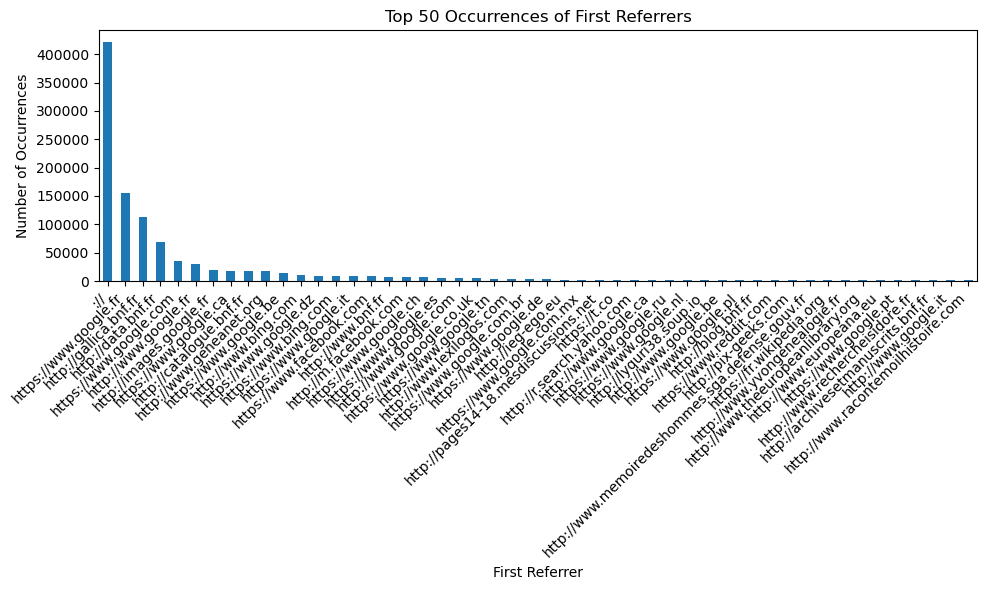

In [132]:
# statistics on the referrers
# Plot the referrer counts
referrer_counts = sessions_df['first_referrer'].value_counts()

# Select the top 50 referrers
top_50_referrers = referrer_counts.head(50)

# Plot the top 50 referrer counts
plt.figure(figsize=(10, 6))
top_50_referrers.plot(kind='bar')
plt.xlabel('First Referrer')
plt.ylabel('Number of Occurrences')
plt.title('Top 50 Occurrences of First Referrers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/referrer.png")
plt.show()

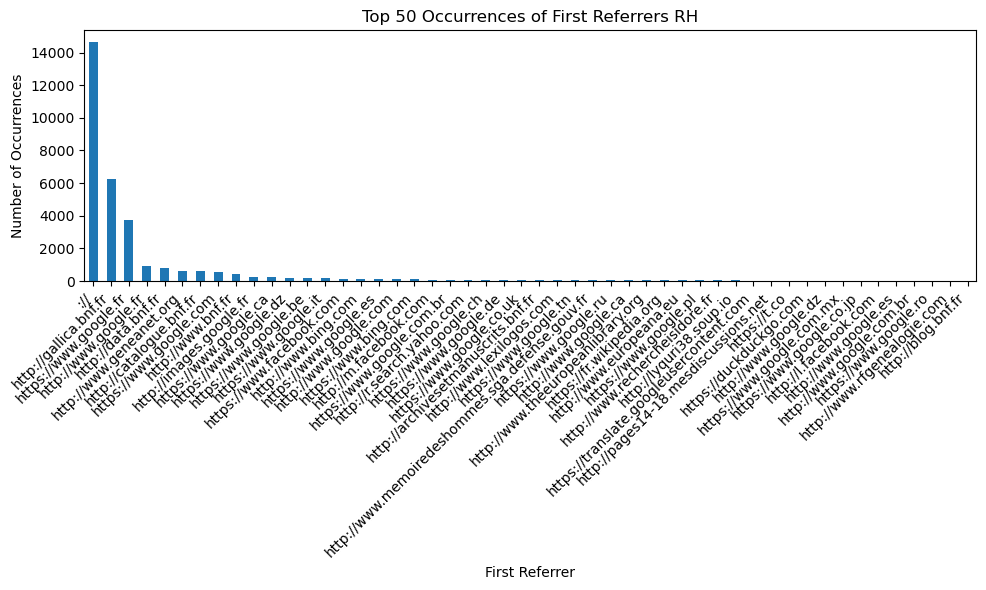

In [133]:
referrer_counts = sessions_rh_df['first_referrer'].value_counts()

# Select the top 50 referrers
top_50_referrers = referrer_counts.head(50)

# Plot the top 50 referrer counts
plt.figure(figsize=(10, 6))
top_50_referrers.plot(kind='bar')
plt.xlabel('First Referrer')
plt.ylabel('Number of Occurrences')
plt.title('Top 50 Occurrences of First Referrers RH')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/referrer_rh.png")
plt.show()

In [129]:
# function to find the hour the session began at
def extract_hour(date_time):
    return pd.to_datetime(date_time).hour


In [134]:
sessions_df.reset_index(drop=True, inplace=True)
sessions_df['hour'] = sessions_df['first_date'].apply(lambda x: extract_hour(x))
sessions_rh_df.reset_index(drop=True, inplace=True)
sessions_rh_df['hour'] = sessions_df['first_date'].apply(lambda x: extract_hour(x))


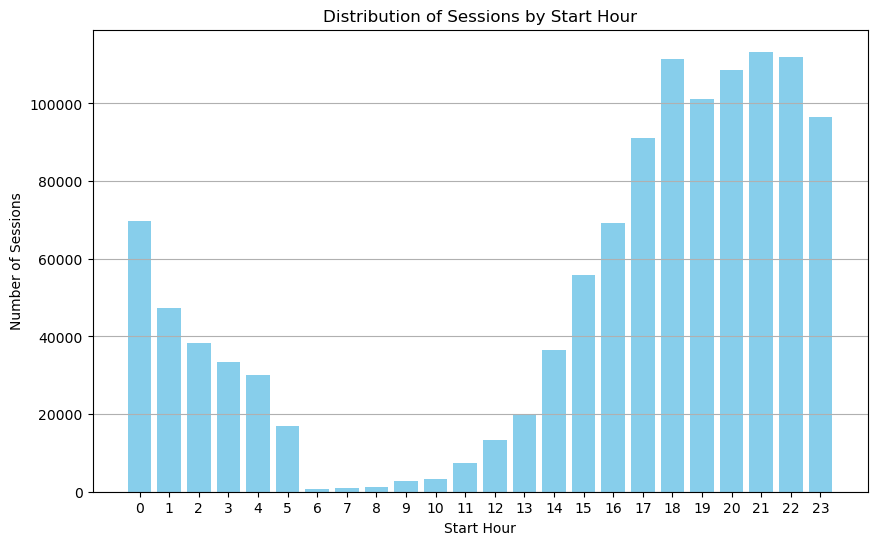

<Figure size 640x480 with 0 Axes>

In [135]:
# Calculate the counts for each start hour
hour_counts = sessions_df['hour'].value_counts().sort_index()

# Plot the distribution of start hours
plt.figure(figsize=(10, 6))
plt.bar(hour_counts.index, hour_counts.values, color='skyblue')
plt.xlabel('Start Hour')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Sessions by Start Hour')
plt.xticks(range(24))
plt.grid(axis='y')
plt.savefig("plots/hours.png")
plt.show()

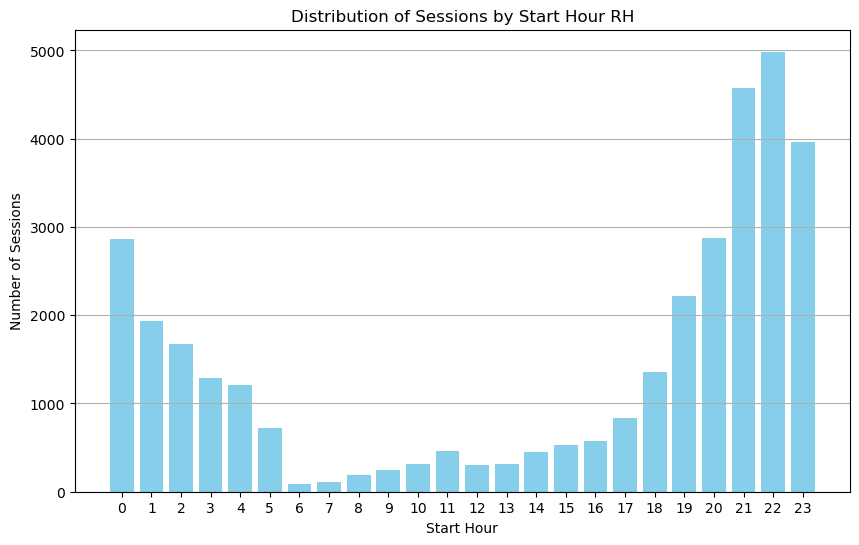

<Figure size 640x480 with 0 Axes>

In [137]:
# Calculate the counts for each start hour
hour_counts = sessions_rh_df['hour'].value_counts().sort_index()

# Plot the distribution of start hours
plt.figure(figsize=(10, 6))
plt.bar(hour_counts.index, hour_counts.values, color='skyblue')
plt.xlabel('Start Hour')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Sessions by Start Hour RH')
plt.xticks(range(24))
plt.grid(axis='y')
plt.savefig("plots/hours_rh.png")
plt.show()

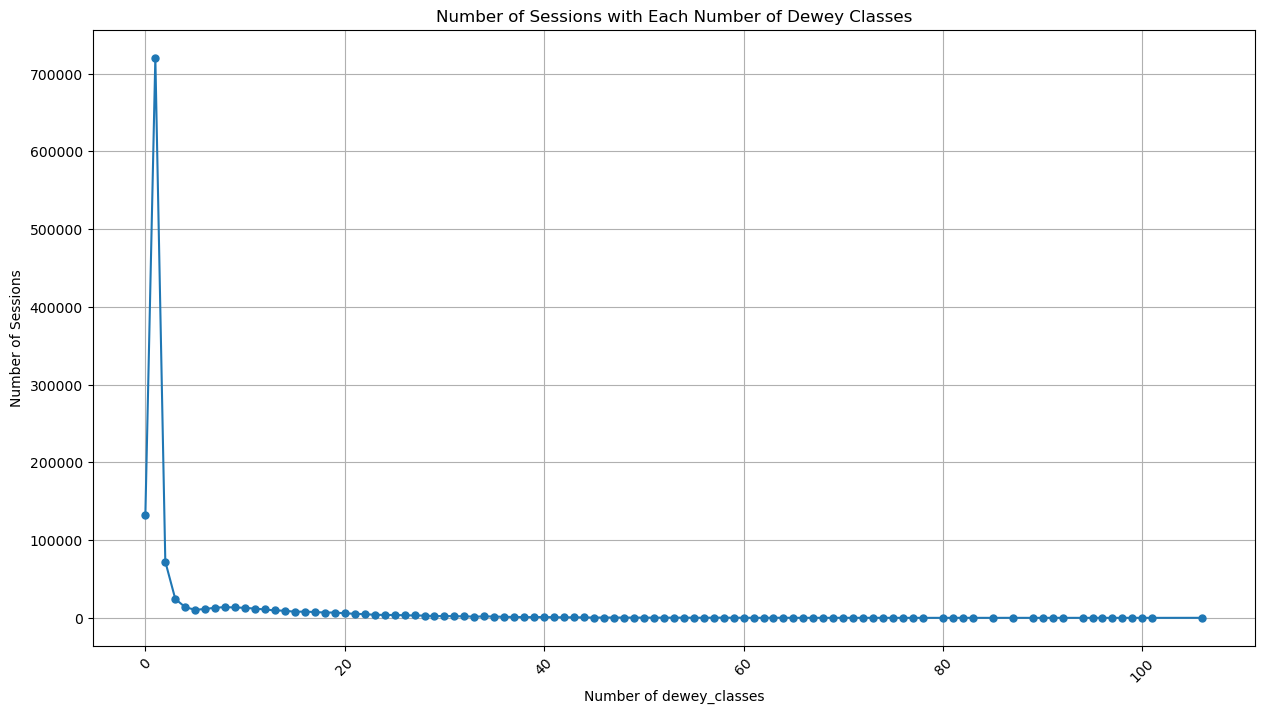

In [143]:
# Calculate the number of sessions that have each number of dewey_classes
dewey_classes_counts = sessions_df['nb_themes'].value_counts().sort_index()

plt.figure(figsize=(15, 8))
plt.plot(dewey_classes_counts.index, dewey_classes_counts.values, marker='o', markersize=5, linestyle='-')
plt.xlabel('Number of dewey_classes')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions with Each Number of Dewey Classes')
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig("plots/nb_themes.png")
plt.show()

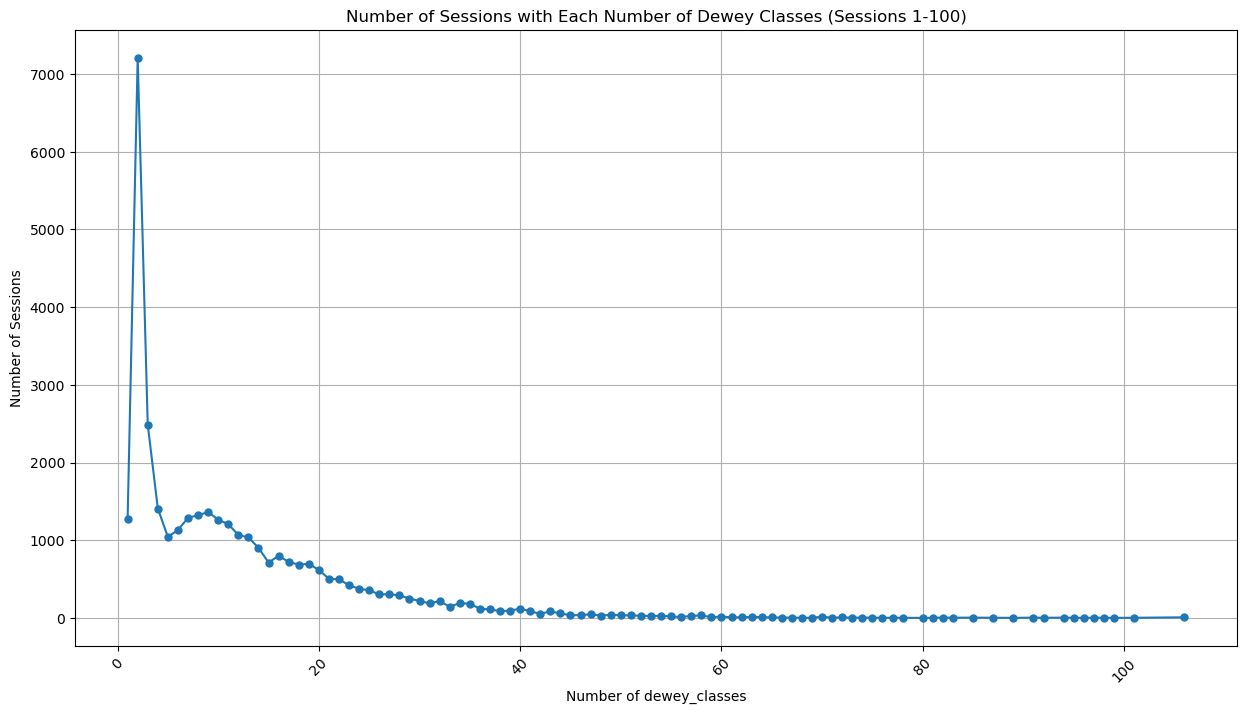

<Figure size 640x480 with 0 Axes>

In [146]:
# Calculate the number of sessions that have each number of dewey_classes
dewey_classes_counts = sessions_rh_df['nb_themes'].value_counts().sort_index()

# Filter dewey_classes counts for sessions 1-100

# Plot the number of sessions with each number of dewey_classes
plt.figure(figsize=(15, 8))
plt.plot(dewey_classes_counts.index, dewey_classes_counts.values, marker='o', markersize=5, linestyle='-')
plt.xlabel('Number of dewey_classes')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions with Each Number of Dewey Classes')
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig("plots/nb_themes_rh.png")
plt.show()


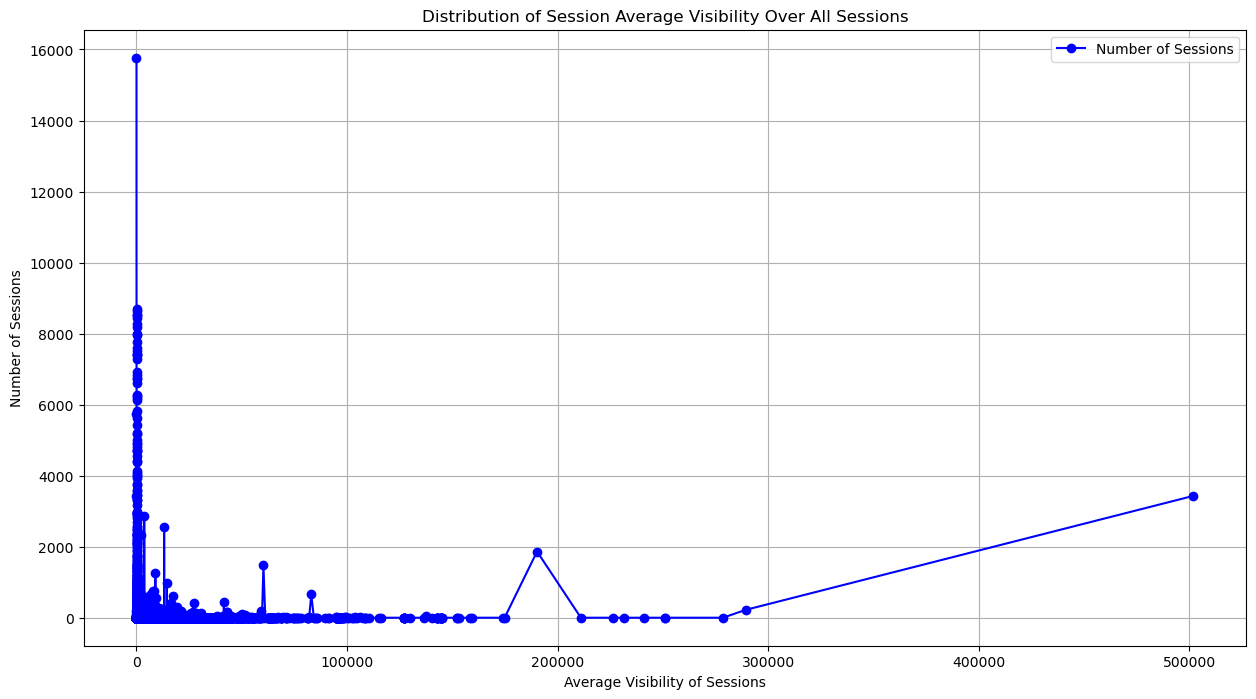

In [163]:
avg_vis = sessions_df['mean_visibility'].value_counts().sort_index()

plt.figure(figsize=(15, 8))

plt.plot(avg_vis.index, avg_vis.values, marker='o', markersize=8, linestyle='-', linewidth=2, color='blue', label='Number of Sessions')

plt.xlabel('Average Visibility of Sessions')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Average Visibility Over All Sessions')
plt.grid(True)
plt.legend()
plt.savefig("plots/avg_vis.png")
plt.show()

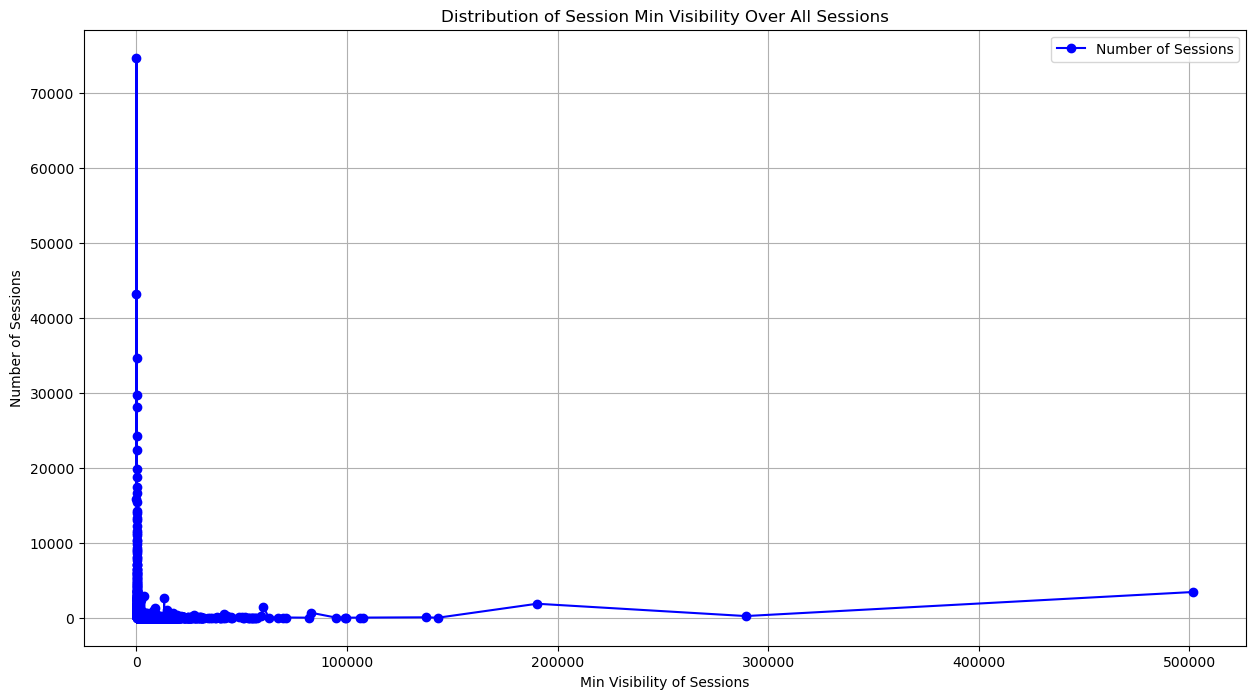

In [164]:
avg_vis = sessions_df['min_visibility'].value_counts().sort_index()

plt.figure(figsize=(15, 8))

plt.plot(avg_vis.index, avg_vis.values, marker='o', linestyle='-', color='blue', label='Number of Sessions')

plt.xlabel('Min Visibility of Sessions')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Min Visibility Over All Sessions')
plt.grid(True)
plt.legend()
plt.savefig("plots/min_vis.png")
plt.show()


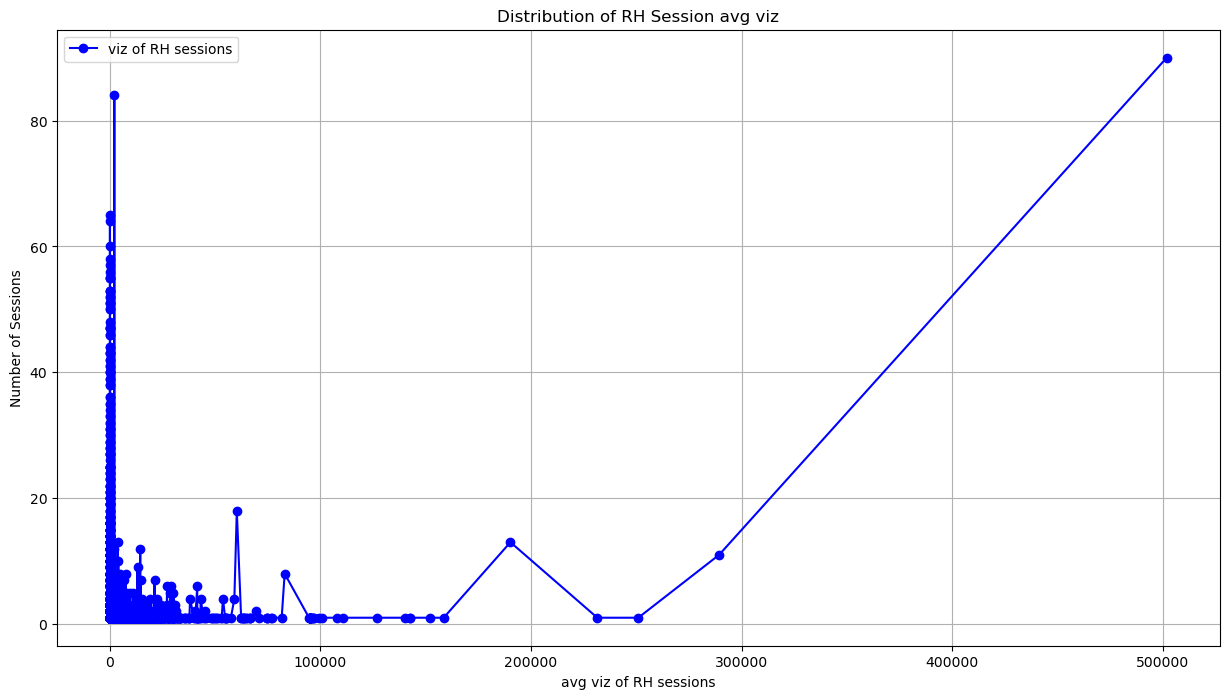

In [165]:

avg_vis = sessions_rh_df['mean_visibility'].value_counts().sort_index()

plt.figure(figsize=(15, 8))

plt.plot(avg_vis.index, avg_vis.values, marker='o', linestyle='-', color='blue', label='viz of RH sessions')


plt.xlabel('avg viz of RH sessions')
plt.ylabel('Number of Sessions')
plt.title('Distribution of RH Session avg viz')
plt.grid(True)
plt.legend()
plt.savefig("plots/avg_vis_rh.png")
plt.show()

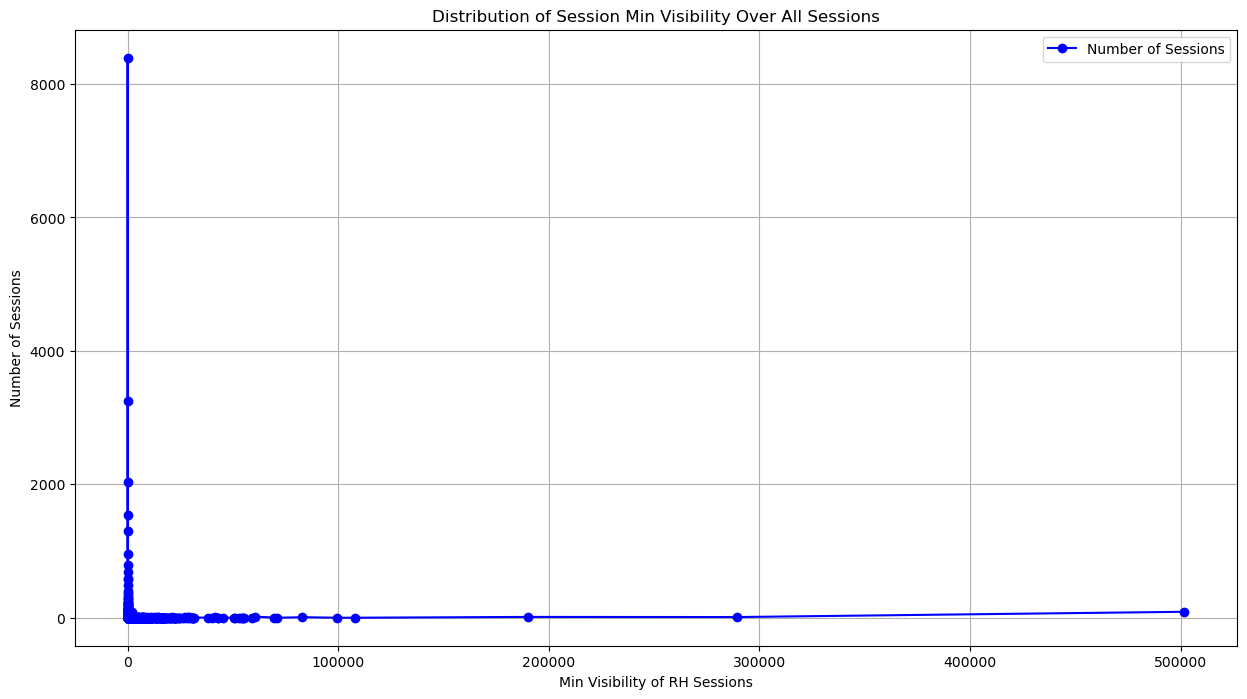

In [166]:
avg_vis = sessions_rh_df['min_visibility'].value_counts().sort_index()

plt.figure(figsize=(15, 8))

plt.plot(avg_vis.index, avg_vis.values, marker='o', linestyle='-', color='blue', label='Number of Sessions')

plt.xlabel('Min Visibility of RH Sessions')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Min Visibility Over All Sessions')
plt.grid(True)
plt.legend()
plt.savefig("plots/min_vis_rh.png")
plt.show()


In [167]:
# add time threshold

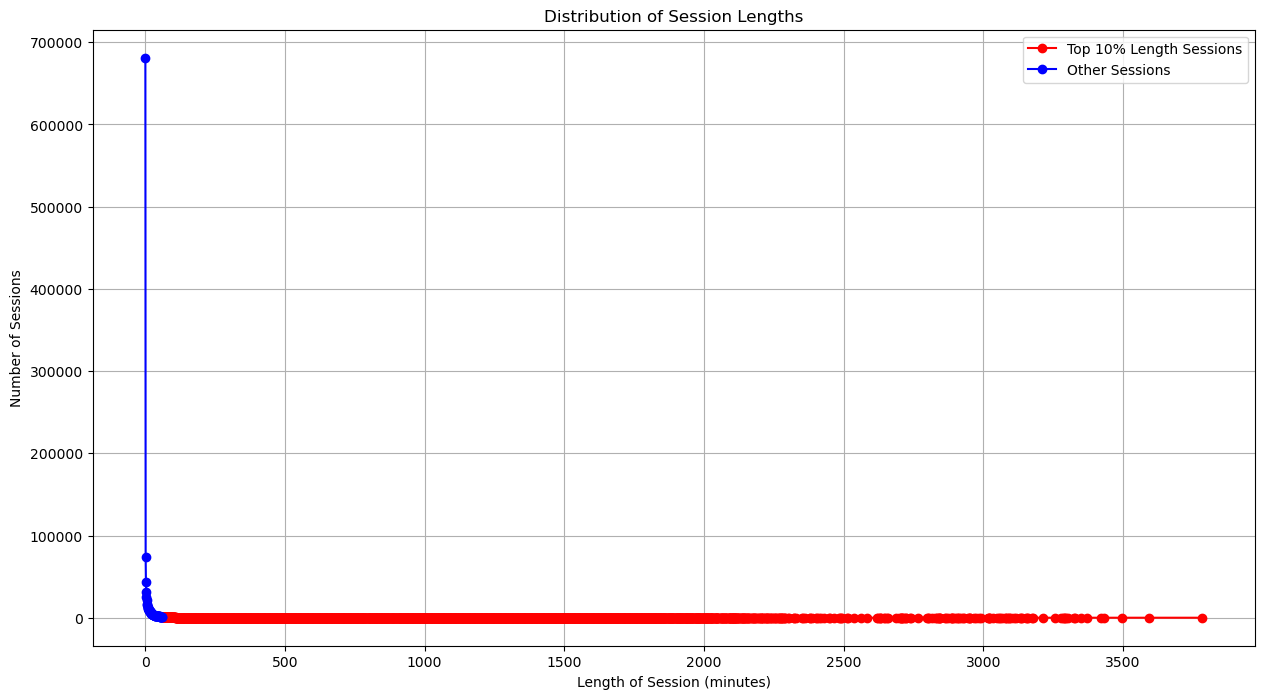

In [169]:
# Separate sessions into top 10% and not in top 10%
top_5_sessions = sessions_df[sessions_df['top_5%_length']]
other_sessions = sessions_df[~sessions_df['top_5%_length']]

# Calculate session lengths count for top 10% and other sessions
top_5_length_count = top_5_sessions['length_minutes'].value_counts().sort_index()
other_length_count = other_sessions['length_minutes'].value_counts().sort_index()

# Plotting the distribution of session lengths using a line plot
plt.figure(figsize=(15, 8))

# Plot top 10% sessions
plt.plot(top_5_length_count.index, top_5_length_count.values, marker='o', linestyle='-', color='red', label='Top 10% Length Sessions')

# Plot other sessions
plt.plot(other_length_count.index, other_length_count.values, marker='o', linestyle='-', color='blue', label='Other Sessions')

plt.xlabel('Length of Session (minutes)')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Lengths')
plt.grid(True)
plt.legend()
plt.savefig("plots/sess_length.png")
plt.show()


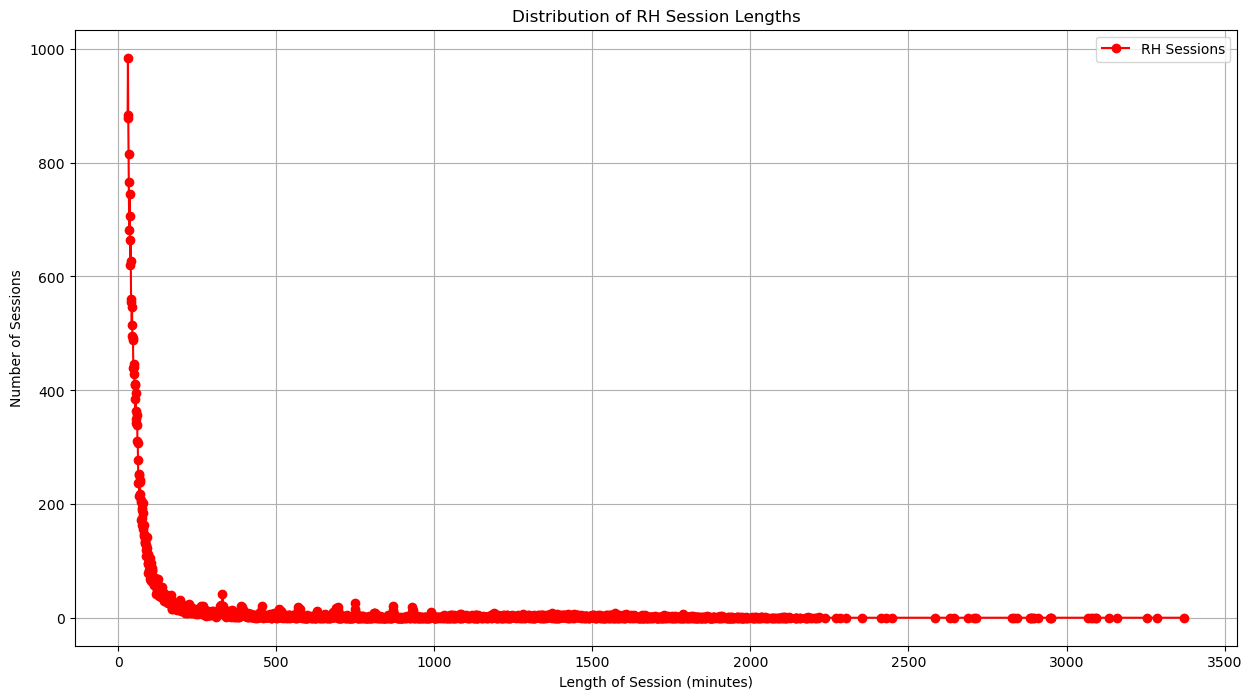

In [170]:
# same stats but on RH
# Calculate session lengths count for top 10% and other sessions
rh_length_count = sessions_rh_df['length_minutes'].value_counts().sort_index()

# Plotting the distribution of session lengths using a line plot
plt.figure(figsize=(15, 8))

# Plot sessions
plt.plot(rh_length_count.index, rh_length_count.values, marker='o', linestyle='-', color='red', label='RH Sessions')

plt.xlabel('Length of Session (minutes)')
plt.ylabel('Number of Sessions')
plt.title('Distribution of RH Session Lengths')
plt.grid(True)
plt.legend()
plt.savefig("plots/sess_length_rh.png")
plt.show()



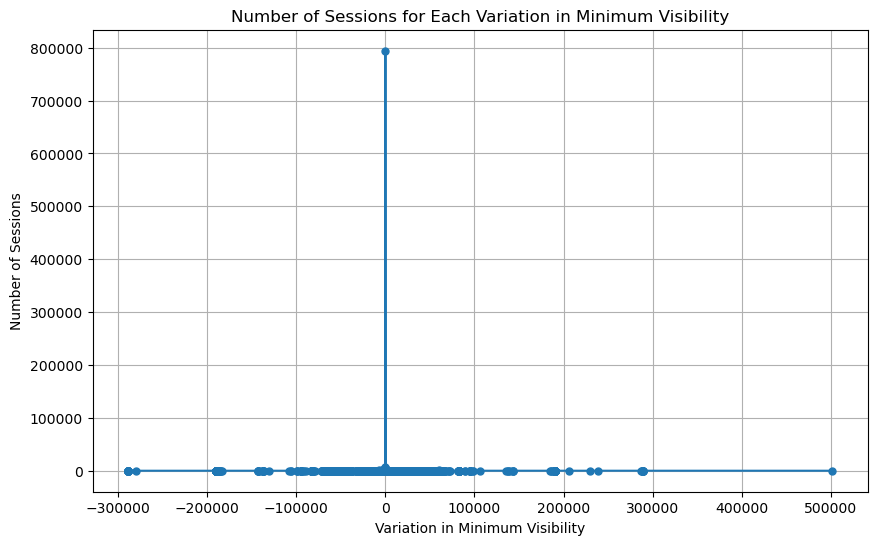

In [177]:
variation_counts = sessions_df['variation_min_vis'].value_counts().sort_index()

# Plot the number of sessions for each unique value of 'variation_min_vis'
plt.figure(figsize=(10, 6))
plt.plot(variation_counts.index, variation_counts.values, marker='o', markersize=5, linestyle='-')
plt.xlabel('Variation in Minimum Visibility')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions for Each Variation in Minimum Visibility')
plt.grid(True)
plt.savefig("plots/var_min.png")
plt.show()

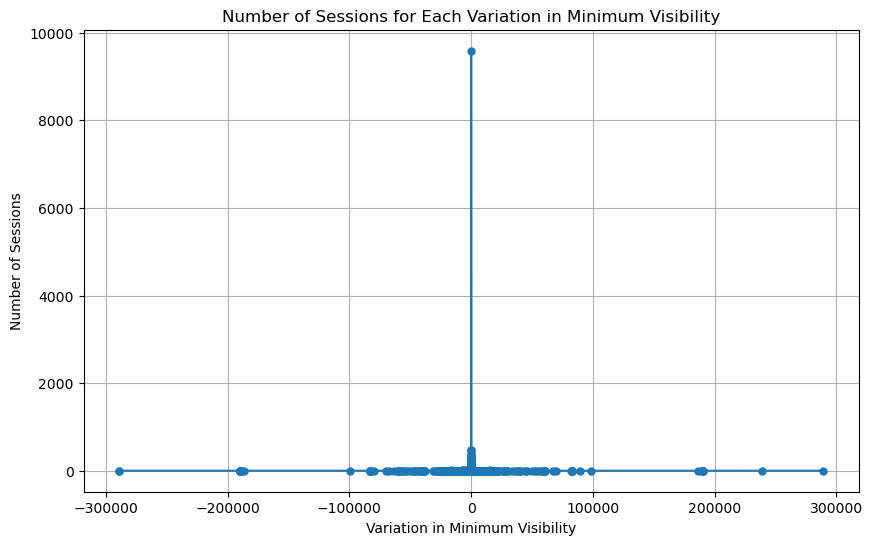

In [178]:
variation_counts = sessions_rh_df['variation_min_vis'].value_counts().sort_index()

# Plot the number of sessions for each unique value of 'variation_min_vis'
plt.figure(figsize=(10, 6))
plt.plot(variation_counts.index, variation_counts.values, marker='o', markersize=5, linestyle='-')
plt.xlabel('Variation in Minimum Visibility RH')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions for Each Variation in Minimum Visibility')
plt.grid(True)
plt.savefig("plots/var_min_rh.png")
plt.show()

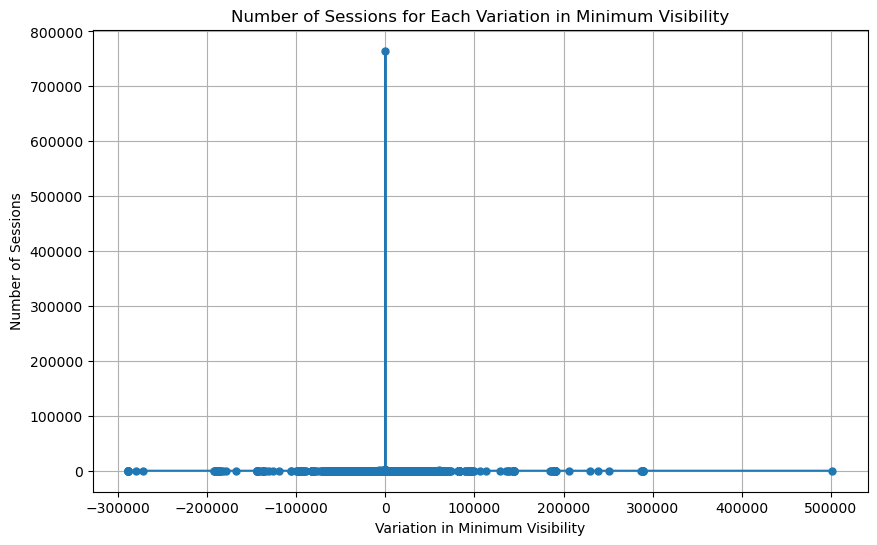

In [179]:
variation_counts = sessions_df['variation_mean_vis'].value_counts().sort_index()

# Plot the number of sessions for each unique value of 'variation_min_vis'
plt.figure(figsize=(10, 6))
plt.plot(variation_counts.index, variation_counts.values, marker='o', markersize=5, linestyle='-')
plt.xlabel('Variation in Mean Visibility')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions for Each Variation in Mean Visibility')
plt.grid(True)
plt.savefig("plots/var_mean.png")
plt.show()

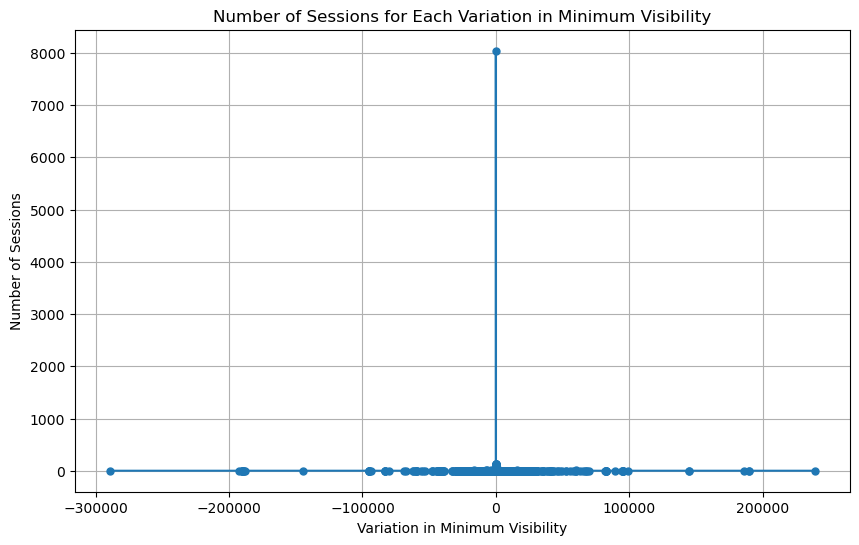

In [180]:
variation_counts = sessions_rh_df['variation_mean_vis'].value_counts().sort_index()

# Plot the number of sessions for each unique value of 'variation_min_vis'
plt.figure(figsize=(10, 6))
plt.plot(variation_counts.index, variation_counts.values, marker='o', markersize=5, linestyle='-')
plt.xlabel('Variation in Mean Visibility RH')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions for Each Variation in Mean Visibility')
plt.grid(True)
plt.savefig("plots/var_mean_rh.png")
plt.show()